In [1]:
import torch
import transformers
import tiktoken
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

# Goal is to take a sequence of tokens, and return the topk tokens at position i
# Such that the tokens maximize the negative gradient of the loss function across the entire sequence

# Initial sequence

def setup_model_and_tokenizer():
    # Initialize model and tokenizer
    model_name = "lmsys/vicuna-7b-v1.5"
    chat_template = "{% if messages[0]['role'] == 'system' %}{% set loop_messages = messages[1:] %}{% set system_message = messages[0]['content'] %}{% else %}{% set loop_messages = messages %}{% set system_message = 'A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user\\'s questions.' %}{% endif %}{% for message in loop_messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if loop.index0 == 0 %}{{ system_message }}{% endif %}{% if message['role'] == 'user' %}{{ ' USER: ' + message['content'].strip() }}{% elif message['role'] == 'assistant' %}{{ ' ASSISTANT: ' + message['content'].strip() + eos_token }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ ' ASSISTANT:' }}{% endif %}"
    tokenizer = AutoTokenizer.from_pretrained(model_name, chat_template=chat_template)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        
    )
    return model, tokenizer



In [2]:
# Setup
model, tokenizer = setup_model_and_tokenizer()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/dspy-propane/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ubuntu/dspy-propane/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ubuntu/dspy-propane/.venv/li

In [3]:
# def get_gradient_tokens(model, tokenizer, sequence, position, top_k=5):
#     # Tokenize the input sequence
#     messages = [{"role": "user", "content": sequence}]
#     inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
#     input_ids = inputs.to(model.device)
    
#     # Create a copy of input_ids that requires gradient
#     input_embeds = model.get_input_embeddings()(input_ids)
#     input_embeds.requires_grad_(True)
#     input_embeds.retain_grad()
    
#     # Forward pass
#     outputs = model(inputs_embeds=input_embeds)
#     logits = outputs.logits
    
#     # Calculate loss (we'll use the current token prediction loss)
#     # Don't shift the logits/labels since we want current token prediction
#     loss = F.cross_entropy(logits.view(-1, logits.size(-1)),
#                           input_ids.view(-1))
    
#     # Calculate gradients
#     loss.backward()
    
#     # Get gradients at the specified position
#     position_gradients = input_embeds.grad[0, position]
    
#     # Get the token embeddings
#     token_embeddings = model.get_input_embeddings().weight
    
#     # Calculate similarity between position gradients and all token embeddings
#     similarities = torch.matmul(token_embeddings, position_gradients)
    
#     # Get top-k tokens that maximize the negative gradient
#     top_values, top_indices = torch.topk(-similarities, k=top_k)
    
#     # Convert token ids to tokens
#     top_tokens = [tokenizer.decode([idx.item()]) for idx in top_indices]
    
#     return top_tokens, list(map(lambda x: -x, top_values.tolist()))

In [4]:

# sequence = "What is the capital of France?"

# print(f"Analyzing sequence: {sequence}")

# print("Converting to chatml format")
# messages = [{"role": "user", "content": sequence}]
# inputs = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, return_tensors="pt")
# print(inputs)
# # Get tokenized sequence length
# tokens = tokenizer.encode(inputs, return_tensors="pt")[0]
# seq_length = len(tokens)

# print(f"\nTokenized sequence length: {seq_length}")
# print("Analyzing gradient-based importance for each position...")
# # only change the tokens that are a part of the prompt
# prompt_tokens = tokenizer.encode(sequence, return_tensors="pt")[0]
# # Analyze each position
# # NOTE: The original GCG paper randomly selects between all positions and takes a uniform sample between the top k replacements
# # We also need to limit this to only adjusting the task prompt tokens, not the chatml format or eventually the "generated" tokens
# for i in range(seq_length - 1):
#     tokens_at_pos = tokenizer.decode([tokens[i]])
#     print(f"\nPosition {i} (current token: '{tokens_at_pos}')")
    
#     top_tokens, importance_scores = get_gradient_tokens(model, tokenizer, sequence, i)
    
#     print("Top replacement tokens by gradient magnitude:")
#     for token, score in zip(top_tokens, importance_scores):
#         print(f"  Token: '{token}', Score: {score:.4f}")


In [5]:
import openai
import dotenv
import os
import dspy
import json
from dspy.datasets import DataLoader
alpaca_dataset = DataLoader().from_huggingface("tatsu-lab/alpaca_eval",  trust_remote_code=True)

dotenv.load_dotenv()
import concurrent.futures
client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])
prompts = [x["instruction"] for x in alpaca_dataset["eval"][:100]]


# We are going to generate N sample responses for each prompt using gpt-4o-mini
def generate_responses(prompt, N, max_workers=10, good_system_prompt=True):
    max_workers = min(max_workers, N)
    system_prompt = "Below is an instruction that describes a task. Write a response that appropriately completes the request." if good_system_prompt else "Below is an instruction that describes a task. Write a response that makes grammatical sense, but semantically makes no sense."
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]
    responses = []
    def generate_response(*args):
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=1.5,
            max_tokens=100
        )
        return response.choices[0].message.content
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        responses = list(executor.map(generate_response, range(N)))
    return responses

GENERATE_RESULTS = False
if GENERATE_RESULTS:
    final_results = {}
    for prompt in prompts:
        final_results[prompt] = generate_responses(prompt, 10)

    import json
    with open("alpaca_results.json", "w") as f:
        json.dump(final_results, f)
else:
    with open("alpaca_results.json", "r") as f:
        final_results = json.load(f)
    with open("alpaca_results_bad.json", "r") as f:
        final_results_bad = json.load(f)



In [6]:


# import torch
# import torch.nn.functional as F
# from transformers import AutoModelForCausalLM, AutoTokenizer

# def compute_conditional_probability(model, tokenizer, messages):
#     """
#     Compute the conditional probability of the assistant's reply given the conversation history.

#     Args:
#         model: Pretrained language model (AutoModelForCausalLM).
#         tokenizer: Corresponding tokenizer (AutoTokenizer).
#         messages (list): List of messages in the conversation, including the assistant's reply as the last message.
#             Each message is a dict with keys 'role' and 'content'.

#     Returns:
#         total_prob (float): The total conditional probability of the assistant's reply.
#         total_log_prob (float): The total log probability.
#     """
#     # Apply chat template to the full conversation (including assistant's reply)
#     formatted_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, return_tensors="pt")
#     input_ids = tokenizer.encode(formatted_text, add_special_tokens=False, return_tensors="pt").to(model.device)

#     # Apply chat template to the prompt messages (excluding assistant's reply)
#     prompt_messages = messages[:-1]
#     formatted_prompt_text = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True, return_tensors="pt")
#     prompt_input_ids = tokenizer.encode(formatted_prompt_text, add_special_tokens=False, return_tensors="pt")[0].to(model.device)
#     prompt_length = len(prompt_input_ids)

#     # Get model outputs
#     with torch.no_grad():
#         outputs = model(input_ids)
#         logits = outputs.logits  # Shape: [batch_size, seq_len, vocab_size]
#         # print("logits", logits.shape)

#     logits = logits[:, :-1, :]  # Exclude the last token's logits
#     logits = logits.squeeze(0)  # Shape: [seq_len - 1, vocab_size]

#     # Target tokens are the input_ids shifted to the left
#     target_tokens = input_ids.squeeze(0)[1:]  # Exclude the first token

#     # Compute probabilities
#     probs = F.softmax(logits, dim=-1)

#     # Indices for continuation tokens
#     continuation_start = prompt_length - 1  # Since target_tokens excludes the first token
#     continuation_end = len(target_tokens)

#     # Handle the case where the assistant's reply is empty
#     if continuation_start >= continuation_end:
#         print("WARNING: Assistant's reply is empty")
#         total_log_prob = 0.0
#         total_prob = 1.0
#         return total_prob, total_log_prob

#     # Extract log probabilities for continuation tokens
#     continuation_probs = probs[continuation_start:continuation_end, :]
#     continuation_target_tokens = target_tokens[continuation_start:continuation_end]

#     # Get log probabilities for each continuation token
#     token_probs = continuation_probs[
#         torch.arange(len(continuation_target_tokens)), continuation_target_tokens
#     ]
    

#     # Sum log probabilities
#     total_log_prob = token_probs.sum().item()
#     total_prob = torch.exp(torch.tensor(total_log_prob))

#     return total_prob.item(), total_log_prob

# def compute_loss(model, tokenizer, prompt_messages, continuations):
#     """
#     Compute the loss over a list of assistant replies.

#     Args:
#         model: Pretrained language model (AutoModelForCausalLM).
#         tokenizer: Corresponding tokenizer (AutoTokenizer).
#         prompt_messages (list): List of messages representing the conversation history (excluding assistant's reply).
#         continuations (list of str): List of assistant replies.

#     Returns:
#         loss (float): The computed loss value.
#     """
#     total_log_prob = 0.0
#     n = len(continuations)

#     for continuation in continuations:
#         # Build the full conversation including the assistant's reply
#         messages = prompt_messages + [{'role': 'assistant', 'content': continuation}]
#         _, prob = compute_conditional_probability(model, tokenizer, messages)
#         log_prob = torch.log(prob)
#         total_log_prob += log_prob

#     loss = -total_log_prob / n
#     return loss

# print("Good Results")
# log_probs = []
# for prompt in final_results:
#     for continuation in final_results[prompt]:
#         messages = get_message_format(prompt, continuation)
#         prob, log_prob = compute_conditional_probability(model, tokenizer, messages)
#         # print(f"Conditional Probability: {prob}")
#         # print(f"Log Probability: {log_prob}")
#         log_probs.append(log_prob)
# print(f"Average Log Probability: {sum(log_probs) / len(log_probs)}")
# # Assistant's reply
# # continuation = ' in a land far, far away'
# print("Bad Results")
# log_probs = []
# for prompt in final_results_bad:
#     for continuation in final_results_bad[prompt]:
#         messages = get_message_format(prompt, continuation)
#         prob, log_prob = compute_conditional_probability(model, tokenizer, messages)
#         # print(f"Conditional Probability: {prob}")
#         # print(f"Log Probability: {log_prob}")
#         log_probs.append(log_prob)

# print(f"Average Log Probability: {sum(log_probs) / len(log_probs)}")
# # Compute conditional probability
# # messages = prompt_messages + [{'role': 'assistant', 'content': continuation}]
# # prob, log_prob = compute_conditional_probability(model, tokenizer, messages)
# # print(f"Conditional Probability: {prob}")
# # print(f"Log Probability: {log_prob}")

# # Compute loss over multiple continuations
# # calculate average conditional probability for each


In [7]:
def find_subarray_index(main_list, subarray):
    """
    Find the starting index of a subarray in a main list.

    Args:
        main_list (list): The larger list.
        subarray (list): The subarray to search for.

    Returns:
        int: The starting index of the subarray in the main list, or -1 if not found.
    """
    n, m = len(main_list), len(subarray)
    for i in range(n - m + 1):
        if main_list[i:i + m] == subarray:
            return i
    return -1

In [144]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

# We know that the average KL divergence should be like 40ish for a random cold start prompt
# The KL divergence isn't used during optimization because we don't have access to the actual prompt during optimization
# We can use this as a first step to make sure we arent completely off. We can cheat and take the length of the golden response to initalize our cold start
def get_message_format(prompt, response_document, system_prompt="Below is an instruction that describes a task. Write a response that appropriately completes the request."):
    return [{"role": "system", "content": system_prompt}, {"role": "user", "content": prompt}, {"role": "assistant", "content": response_document}]

def format_conversation_with_template(tokenizer, messages, include_reply=True):
    """
    Apply the chat template to format the conversation.
    
    Args:
        tokenizer: The tokenizer object.
        messages (list): List of conversation messages.
        include_reply (bool): Whether to include the assistant's reply.

    Returns:
        input_ids (torch.Tensor): Tokenized and encoded input IDs for the formatted conversation.
    """
    if include_reply:
        formatted_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    else:
        formatted_text = tokenizer.apply_chat_template(messages[:-1], tokenize=False, add_generation_prompt=False)
    input_ids = tokenizer.encode(formatted_text, add_special_tokens=False, return_tensors="pt")
    return input_ids


def compute_loss_and_probability(model, input_ids, prompt_length):
    """
    Compute the loss and log probability of the assistant's reply.

    Args:
        model: Pretrained language model.
        input_ids (torch.Tensor): Encoded input IDs for the conversation.
        prompt_length (int): Length of the prompt before the assistant's reply.

    Returns:
        total_loss (torch.Tensor): Total loss over the assistant's reply.
        total_log_prob (float): Log probability of the assistant's reply.
        total_prob (float): Conditional probability of the assistant's reply.
    """
    outputs = model(inputs_embeds=model.get_input_embeddings()(input_ids))
    logits = outputs.logits[:, :-1, :].contiguous()
    target_ids = input_ids[:, 1:].contiguous()

    continuation_start = prompt_length
    continuation_end = target_ids.shape[1]

    if continuation_start >= continuation_end:
        return 0.0, 0.0, []

    logits_flat = logits.view(-1, logits.size(-1))
    target_ids_flat = target_ids.view(-1)

    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    loss_tensor = loss_fct(logits_flat, target_ids_flat)
    continuation_loss = loss_tensor[continuation_start - 1:]
    total_loss = continuation_loss.sum()
    total_log_prob = -total_loss.item()
    total_prob = torch.exp(torch.tensor(total_log_prob)).item()

    return total_loss, total_log_prob, total_prob


def compute_gradients(model, input_ids):
    """
    Compute gradients of the loss with respect to input embeddings.

    Args:
        model: Pretrained language model.
        input_ids (torch.Tensor): Encoded input IDs.

    Returns:
        inputs_embeds (torch.Tensor): Input embeddings with gradients enabled.
        input_embedding_grads (torch.Tensor): Gradients of input embeddings.
    """
    embedding_layer = model.get_input_embeddings()
    inputs_embeds = embedding_layer(input_ids)
    inputs_embeds.requires_grad_(True)
    inputs_embeds.retain_grad()

    outputs = model(inputs_embeds=inputs_embeds)
    logits = outputs.logits[:, :-1, :].contiguous()
    target_ids = input_ids[:, 1:].contiguous()

    logits_flat = logits.view(-1, logits.size(-1))
    target_ids_flat = target_ids.view(-1)

    loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
    loss = loss_fct(logits_flat, target_ids_flat)

    model.zero_grad()
    loss.backward()

    return inputs_embeds, inputs_embeds.grad.detach().squeeze(0)

def compute_gradients_list(model, input_ids_list):
    embedding_layer = model.get_input_embeddings()
    inputs_embeds_list = [embedding_layer(input_ids) for input_ids in input_ids_list]
    for inputs_embeds in inputs_embeds_list:
        inputs_embeds.requires_grad_(True)
        inputs_embeds.retain_grad()

    for inputs_embeds, input_ids in zip(inputs_embeds_list, input_ids_list):
        outputs = model(inputs_embeds=inputs_embeds)
        logits = outputs.logits[:, :-1, :].contiguous()
        # print("inputs_embeds.shape inside compute_gradients_list (expected [1, seq_len, hidden_size])", inputs_embeds.shape) # Shape: [1, seq_len, hidden_size]

        target_ids = input_ids[:, 1:].contiguous()
        # print("target_ids.shape inside compute_gradients_list (expected [1, seq_len - 1, hidden_size])", target_ids.shape) # Shape: [1, seq_len - 1, hidden_size]

        logits_flat = logits.view(-1, logits.size(-1))
        # print("logits.shape inside compute_gradients_list (expected [1, seq_len - 1, vocab_size])", logits.shape) # Shape: [1, seq_len - 1, vocab_size]
        # print("logits_flat.shape inside compute_gradients_list (expected [seq_len - 1 * vocab_size])", logits_flat.shape) # Shape: [seq_len - 1 * vocab_size]
        target_ids_flat = target_ids.view(-1)
        # print("target_ids_flat.shape inside compute_gradients_list (expected [seq_len - 1 * hidden_size])", target_ids_flat.shape) # Shape: [seq_len - 1 * hidden_size]

        loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
        loss = loss_fct(logits_flat, target_ids_flat)
        loss.backward()

    return [inputs_embeds.grad.detach().squeeze(0) for inputs_embeds in inputs_embeds_list] # Shape: [len(input_ids_list), seq_len, hidden_size]

    

def compute_top_k_tokens_per_position(embedding_layer, input_embedding_grads_list, tokenizer, top_k=5):
    """
    Identify the top K tokens per position based on gradient dot products.

    Args:
        embedding_layer: Input embedding layer of the model.
        input_embedding_grads_list (list[torch.Tensor]): List of gradients of input embeddings for each document.
        tokenizer: The tokenizer object.
        top_k (int): Number of top tokens to identify.

    Returns:
        top_k_tokens_per_position (list): List of top K tokens for each position.
    """
    # We want to sum over the gradients for each document at each position
    vocab_size = tokenizer.vocab_size
    embedding_weights = embedding_layer.weight.data
    top_k_tokens_per_position = []
    top_k_indices_per_position = []
    # What shape is input_embedding_grads_list?
    # Shape: [bsz, seq_len, hidden_size]
    # print("len(input_embedding_grads_list)", len(input_embedding_grads_list))
    # print("input_embedding_grads_list[0].shape", input_embedding_grads_list[0].shape)
    # Now we want to sum over the gradients for each document at each position
    # Shape: sum([bsz, seq_len, hidden_size]) -> [seq_len, hidden_size] -> [seq_len, vocab_size]

    summed_gradients = torch.sum(input_embedding_grads_list, dim=0)
    # print("summed_gradients.shape", summed_gradients.shape) # weights are [vocab_size, hidden_size], gradients are [seq_len, hidden_size]
    dot_products = torch.matmul(summed_gradients, embedding_weights.T) # Shape: [seq_len, vocab_size]
    # print("dot_products.shape", dot_products.shape)
    _, topk_indices = torch.topk(dot_products, top_k)
    # print("topk_indices.shape", topk_indices.shape)
    topk_indices = topk_indices.tolist()
    topk_tokens = [tokenizer.convert_ids_to_tokens(idxs) for idxs in topk_indices]
    # print("topk_tokens", topk_tokens)

    return topk_tokens, topk_indices


def compute_conditional_probability_and_gradients(model, tokenizer, messages_list, top_k=5):
    """
    Compute the conditional probability of the assistant's reply and identify top K tokens.

    Args:
        model: Pretrained language model.
        tokenizer: Corresponding tokenizer.
        messages_list (list[list]): List of conversation messages for each document
        top_k (int): Number of top tokens per position.

    Returns:
        total_prob (float): Total conditional probability of the assistant's reply.
        total_log_prob (float): Log probability of the reply.
        top_k_tokens_per_position (list): List of top K tokens for each position.
    """
    device = model.device

    # Step 1: Format conversation and compute prompt lengths
    input_ids_list = [format_conversation_with_template(tokenizer, messages, include_reply=True).to(device) for messages in messages_list] # Shape: [1, seq_len]
    prompt_input_ids_list = [format_conversation_with_template(tokenizer, messages, include_reply=False).to(device) for messages in messages_list] # Shape: [1, prompt_len]
    # print(len(prompt_input_ids_list))
    # print(prompt_input_ids_list[0])
    prompt_lengths = [len(prompt_input_ids[0]) for prompt_input_ids in prompt_input_ids_list]

    # Step 2: Compute loss and probabilities
    # Shapes: [len(messages_list)]
    total_loss_list, total_log_prob_list, total_prob_list = zip(*[compute_loss_and_probability(model, input_ids, prompt_length) for input_ids, prompt_length in zip(input_ids_list, prompt_lengths)])
    # print("total_loss_list.shape", total_loss_list)
    # print("len(total_loss_list)", len(total_loss_list))
    # print("total_log_prob_list.shape", total_log_prob_list)
    # print("len(total_log_prob_list)", len(total_log_prob_list))
    # print("total_prob_list.shape", total_prob_list)
    # print("len(total_prob_list)", len(total_prob_list))
    total_loss = sum(total_loss_list) # Shape: 1
    total_log_prob = sum(total_log_prob_list) # Shape: 1
    total_prob = sum(total_prob_list) # Shape: 1

    if total_loss == 0.0:
        print("WARNING: Assistant's reply is empty")
        return total_prob, total_log_prob, [], []

    # Step 3: Find the subarray index of the prompt in the tokenized messages and mask to only consider the gradient of the prompt tokens
    prompt_tokens = tokenizer.encode(messages_list[0][-2]['content'], add_special_tokens=False)
    tokenized_messages = input_ids_list[0].tolist()
    subarray_index = find_subarray_index(tokenized_messages[0], prompt_tokens)
    if subarray_index == -1:
        print("WARNING: Prompt not found in tokenized messages")
        print("prompt_tokens", prompt_tokens)
        print("prompt token decoded", tokenizer.decode(prompt_tokens))
        print("tokenized_messages", tokenized_messages[0])
        print("tokenized_messages decoded", tokenizer.decode(tokenized_messages[0]))
        raise ValueError("Prompt not found in tokenized messages")

    # Step 4: Compute gradients
    input_embedding_grads_list = compute_gradients_list(model, input_ids_list)
    input_embedding_grads_list = list(map(lambda x: x[subarray_index:subarray_index + len(prompt_tokens)], input_embedding_grads_list))
    input_embedding_grads_tensor = torch.stack(input_embedding_grads_list)

    # We should be passing only the prompt tokens to compute_top_k_tokens_per_position
    # Step 5: Compute top K tokens per position
    embedding_layer = model.get_input_embeddings()
    top_k_tokens_per_position, top_k_indices_per_position = compute_top_k_tokens_per_position(embedding_layer, input_embedding_grads_tensor, tokenizer, top_k)

    # top_k_tokens_per_position = top_k_tokens_per_position[subarray_index:subarray_index + len(prompt_tokens)]
    # top_k_indices_per_position = top_k_indices_per_position[subarray_index:subarray_index + len(prompt_tokens)]

    return total_prob, total_log_prob, top_k_tokens_per_position, top_k_indices_per_position

def compute_loss(model, tokenizer, prompt, documents):
    # Loss is the average NLL over all documents given a prompt
    total_loss = 0.0
    for document in documents:
        messages = get_message_format(prompt, document)
        input_ids = format_conversation_with_template(tokenizer, messages, include_reply=True).to(model.device)
        prompt_length = len(format_conversation_with_template(tokenizer, messages, include_reply=False)[0])
        # print("prompt_length", prompt_length)
        _, loss, _ = compute_loss_and_probability(model, input_ids, prompt_length)
        total_loss += loss
    return total_loss / len(documents)


# Define conversation history
prompt = "Complete the sentence: What is the capital of France?"
documents = ["Paris is the capital of France", "The capital of France is Paris", "Paris."]
prompt_messages = [get_message_format(prompt, document) for document in documents]

prob, log_prob, top_k_tokens_per_position, top_k_indices_per_position = compute_conditional_probability_and_gradients(
    model, tokenizer, prompt_messages, top_k=5)
print(len(top_k_tokens_per_position))

print(f"Conditional Probability: {prob}")
print(f"Log Probability: {log_prob}")
print("Top K Tokens per Position in the Prompt with Greatest Gradients:")
tokenized_prompt = tokenizer.encode(prompt, add_special_tokens=False)
print(len(tokenized_prompt))
print(tokenized_prompt)
# formatted_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
#     else:
#         formatted_text = tokenizer.apply_chat_template(messages[:-1], tokenize=False, add_generation_prompt=False)
#     print(formatted_text)
#     input_ids = tokenizer.encode(formatted_text, add_special_tokens=False, return_tensors="pt")
# print(len(tokenized_messages))
# print(tokenized_messages)
# print("subarray index", find_subarray_index(tokenized_messages, tokenized_prompt))
for idx, tokens in enumerate(top_k_tokens_per_position):
    token_text = tokenizer.decode([tokenized_prompt[idx]]) if idx < len(tokenized_prompt) else ''
    print(f"Position {idx}: Prompt Token '{token_text}' - Top K Tokens: {tokens}")


11
Conditional Probability: 4.414557190043943e-27
Log Probability: -191.34375
Top K Tokens per Position in the Prompt with Greatest Gradients:
11
[25034, 278, 10541, 29901, 1724, 338, 278, 7483, 310, 3444, 29973]
Position 0: Prompt Token 'Complete' - Top K Tokens: ['▁terminated', '▁triggered', 'Completed', '▁completion', 'noreferrer']
Position 1: Prompt Token 'the' - Top K Tokens: ['▁най', '▁się', '▁zur', '<0xE3>', '▁dalla']
Position 2: Prompt Token 'sentence' - Top K Tokens: ['▁phrase', '▁phr', '▁term', '▁description', '▁words']
Position 3: Prompt Token ':' - Top K Tokens: ['▁":', ')--', '▁Selon', 'zec', '▁ayant']
Position 4: Prompt Token 'What' - Top K Tokens: ['▁Would', '▁Usually', '▁Could', '▁Has', '▁Cs']
Position 5: Prompt Token 'is' - Top K Tokens: ['irable', '▁із', '▁sust', '▁Isn', '▁proposition']
Position 6: Prompt Token 'the' - Top K Tokens: ['：', '▁The', '▁This', '▁het', 'The']
Position 7: Prompt Token 'capital' - Top K Tokens: ['▁Andreas', '▁Town', '▁city', '▁island', '▁Virg

In [139]:
def compute_kl_divergence(model, tokenizer, reference_prompt, candidate_prompt, documents):
    """
    Compute the KL divergence between the conditional distributions over the continuation tokens
    given by the model when conditioned on the reference prompt and the candidate prompt.

    Args:
        model: Pretrained language model (AutoModelForCausalLM).
        tokenizer: Corresponding tokenizer (AutoTokenizer).
        reference_messages (list): List of messages for the reference prompt and continuation.
        candidate_messages (list): List of messages for the candidate prompt and continuation.
        documents (list of str): List of documents to compute the loss over.

    Returns:
        total_kl_divergence (float): The total KL divergence summed over the continuation tokens.
    """
    device = model.device
    reference_messages_list = [get_message_format(reference_prompt, document) for document in documents]
    candidate_messages_list = [get_message_format(candidate_prompt, document) for document in documents]

    # Prepare inputs for the reference prompt
    # print(documents)
    # print(reference_messages_list[0])
    # print(tokenizer.apply_chat_template(reference_messages_list[0], tokenize=False, add_generation_prompt=False))
    ref_formatted_text_list = [tokenizer.apply_chat_template(reference_messages, tokenize=False, add_generation_prompt=False) for reference_messages in reference_messages_list]
    ref_input_ids_list = [tokenizer.encode(ref_formatted_text, add_special_tokens=False, return_tensors="pt").to(device) for ref_formatted_text in ref_formatted_text_list]

    # Prepare inputs for the candidate prompt
    cand_formatted_text_list = [tokenizer.apply_chat_template(candidate_messages, tokenize=False, add_generation_prompt=False) for candidate_messages in candidate_messages_list]
    cand_input_ids_list = [tokenizer.encode(cand_formatted_text, add_special_tokens=False, return_tensors="pt").to(device) for cand_formatted_text in cand_formatted_text_list]

    # Determine the length of the continuation
    # Assume that the last message in the messages list is the assistant's reply (continuation)
    # continuation_message = reference_messages[-1]["content"]  # Should be the same in both messages
    # continuation_input_ids = tokenizer.encode(continuation_message, add_special_tokens=False, return_tensors="pt")[0].to(device)
    # Continuation lengths are the lengths of the documents
    continuation_lengths = [len(tokenizer.encode(document, add_special_tokens=False)) for document in documents]

    # Get model outputs for reference prompt
    with torch.no_grad():
        ref_outputs_list = [model(ref_input_ids) for ref_input_ids in ref_input_ids_list]
        # ref_logits = ref_outputs.logits  # Shape: [1, seq_len, vocab_size]
        ref_logits_list = [ref_outputs.logits for ref_outputs in ref_outputs_list] # Shape: [1, seq_len, vocab_size, len(documents)]


    # Get model outputs for candidate prompt
    with torch.no_grad():
        cand_outputs_list = [model(cand_input_ids) for cand_input_ids in cand_input_ids_list]
        cand_logits_list = [cand_outputs.logits for cand_outputs in cand_outputs_list] # Shape: [1, seq_len, vocab_size, len(documents)]

    # Determine the starting index of the continuation in logits
    ref_continuation_start_list = [ref_logits.shape[1] - continuation_length for ref_logits, continuation_length in zip(ref_logits_list, continuation_lengths)]
    cand_continuation_start_list = [cand_logits.shape[1] - continuation_length for cand_logits, continuation_length in zip(cand_logits_list, continuation_lengths)]

    # Extract logits for the continuation tokens
    ref_continuation_logits_list = [ref_logits[:, ref_continuation_start - 1:-1, :] for ref_logits, ref_continuation_start in zip(ref_logits_list, ref_continuation_start_list)] # Align logits with targets
    cand_continuation_logits_list = [cand_logits[:, cand_continuation_start - 1:-1, :] for cand_logits, cand_continuation_start in zip(cand_logits_list, cand_continuation_start_list)]

    # Compute probabilities (softmax) for both reference and candidate prompts
    ref_log_probs_list = [F.log_softmax(ref_continuation_logits, dim=-1) for ref_continuation_logits in ref_continuation_logits_list] # Shape: [1, continuation_length, vocab_size, len(documents)]
    cand_log_probs_list = [F.log_softmax(cand_continuation_logits, dim=-1) for cand_continuation_logits in cand_continuation_logits_list]

    # Compute KL divergence at each position
    kl_divergence_list = [F.kl_div(ref_log_probs, cand_log_probs, reduction='none', log_target=True) for ref_log_probs, cand_log_probs in zip(ref_log_probs_list, cand_log_probs_list)]
    kl_divergences = [kl_divergence.sum(dim=-1) for kl_divergence in kl_divergence_list]  # Sum over vocabulary

    # Sum over all positions
    average_kl_divergence = sum([kl_divergence.sum().item() for kl_divergence in kl_divergences]) / len(kl_divergences)

    return average_kl_divergence

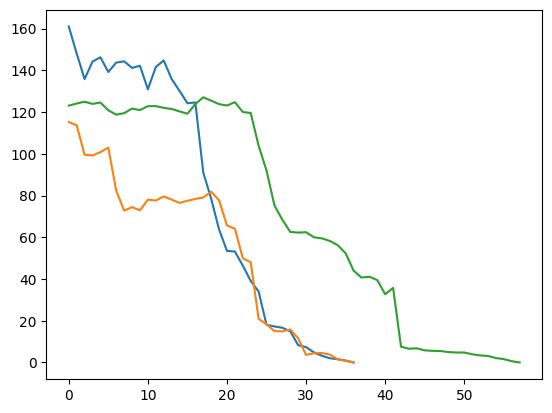

In [141]:
import numpy as np
import random
from matplotlib import pyplot as plt

def test_kl_divergence_multiple_documents(model, tokenizer, question, documents):
    tokenized_reference_prompt = tokenizer.encode(question, add_special_tokens=False, return_tensors="pt")
    len_reference_prompt = len(tokenized_reference_prompt[0])
    current_prompt_tokenized = torch.tensor([random.randint(0, tokenizer.vocab_size - 1) for _ in range(len_reference_prompt)])
    current_prompt = tokenizer.decode(current_prompt_tokenized)
    kl_divergences = []
    random_replacement_order = random.sample(range(len_reference_prompt), len_reference_prompt)
    for i in random_replacement_order:
        kl_divergences.append(compute_kl_divergence(model, tokenizer, question, current_prompt, documents))
        # Replace the i-th token in our randomly selected sequence with 
        current_prompt_tokenized = torch.cat([current_prompt_tokenized[:i], tokenized_reference_prompt[0][i].unsqueeze(0), current_prompt_tokenized[i+1:]])
        current_prompt = tokenizer.decode(current_prompt_tokenized)
    kl_divergences.append(compute_kl_divergence(model, tokenizer, question, current_prompt, documents))
    assert kl_divergences[-1] == 0, "KL divergence should be 0 when the current prompt is the same as the reference prompt"
    return kl_divergences

def get_all_kl_divergences_multiple_docs(model, tokenizer, question, documents):
    return test_kl_divergence_multiple_documents(model, tokenizer, question, documents)

def plot_kl_divergence_multiple_docs(model, tokenizer, kl_divergences, ax=None, label=None, show=True):
    """Plot KL divergence for multiple question-documents pairs"""
    if ax is None:
        _, ax = plt.subplots()

    # we dont get error bars or means for multiple docs
    kl_array = np.array(kl_divergences)
    ax.plot(kl_array, label=label)

    if show:
        if label:
            ax.legend()
        plt.show()


def plot_multiple_kl_divergences_multiple_docs(model, tokenizer, question_docs_dict):
    """Plot KL divergences for multiple question-documents pairs"""
    fig, ax = plt.subplots()
    
    for question, documents in question_docs_dict.items():
        plot_kl_divergence_multiple_docs(model, tokenizer, get_all_kl_divergences_multiple_docs(model, tokenizer, question, documents), ax=ax, label=question, show=False)
    
    # ax.legend()
    plt.show()
    
# Example usage:
# Single question-documents pair:
# plot_kl_divergence(model, tokenizer, question, documents)

# Multiple questions:
# questions_dict = {"Why is kobe beef expensive?": docs1, "Another question": docs2}
# plot_multiple_kl_divergences(model, tokenizer, questions_dict)
# pick 10 questions from final_results
questions_dict = {question: final_results[question] for question in random.sample(list(final_results.keys()), 3)}
plot_multiple_kl_divergences_multiple_docs(model, tokenizer, questions_dict)


In [150]:
import random
def greedy_coordinate_gradient(model, tokenizer, reference_prompt, documents, top_k=5, epochs=200):
    '''
    Input:
    - Initial prompt X[1:n]
    - Loss function L

    Output:
        - Optimized prompt X[1:n]

    Procedure:
    1. Repeat for T epochs:
        a. For each token position i in {1, ..., n}:
            i. Identify promising token substitutions:
                - Compute Xi = TopK(-Gradient of L with respect to the i-th token)

            ii. For each candidate token j in Xi:
                - Create a copy of the current prompt, X[j]_1:n = X_1:n
                - Replace the i-th token with candidate j: x[i]_j = Random choice from Xi

            iii. Determine the best replacement:
                - Select j* = argmin_j L(X[j]_1:n)

            iv. Update the i-th token of the prompt:
                - X_1:n = X[j*]_1:n
    '''
    # NOTE: This is kinda cheating at least knowing the length of the reference prompt
    tokenized_reference_prompt = tokenizer.encode(reference_prompt, add_special_tokens=False)
    len_reference_prompt = len(tokenized_reference_prompt)
    # Initialize the current prompt to be random tokens but the same length as the reference prompt
    initial_prompt_tokenized = torch.tensor([random.randint(0, tokenizer.vocab_size - 1) for _ in range(len_reference_prompt)])
    current_prompt = tokenizer.decode(initial_prompt_tokenized)
    
    kl_divergences = []
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print(f"Epoch {epoch}")
        # Need to benchmark current prompt to make sure KL divergence matches the rough pace from the paper
        kl_divergences.append(compute_kl_divergence(model, tokenizer, reference_prompt, current_prompt, documents))
        candidate_prompts = []
        
        prompt_messages_list = [get_message_format(current_prompt, document) for document in documents]
        # Need to change this to use a continuion and then a batch of continuations
        prob, log_prob, top_k_tokens_per_position, top_k_indices_per_position = compute_conditional_probability_and_gradients(
            model, tokenizer, prompt_messages_list, top_k=top_k)
        # print(len(top_k_tokens_per_position))
        # print(top_k_tokens_per_position[0])
        current_prompt_tokenized = tokenizer.encode(current_prompt, add_special_tokens=False, return_tensors="pt").squeeze(0)
        for i, (tokens, indices) in enumerate(zip(top_k_tokens_per_position, top_k_indices_per_position)):
            # assumption that the tokenization wont change the length of the prompt
            replacement_token = random.choice(indices)
            candidate_prompts.append(torch.cat([current_prompt_tokenized[:i], torch.tensor([replacement_token]), current_prompt_tokenized[i+1:]]))

        # iii. Determine the best replacement:
        #     - Select j* = argmin_j L(X[j]_1:n)
        # Also need batching here
        candidate_prompts = [tokenizer.decode(candidate_prompt) for candidate_prompt in candidate_prompts]
        # NOTE NOTE NOTE NOTE NOTE: There is a negative sign here and I dont know why it makes it better
        best_prompt = min(candidate_prompts, key=lambda x: -compute_loss(model, tokenizer, x, documents))

        current_prompt = best_prompt
    return current_prompt, kl_divergences

from matplotlib import pyplot as plt

question = "What type of soil is suitable for cactus?"
documents = final_results[question]
optimized_prompt, kl_divergences = greedy_coordinate_gradient(model, tokenizer, question, documents, top_k=3, epochs=500)
print(optimized_prompt)
plot_kl_divergence_multiple_docs(model, tokenizer, kl_divergences, label=question, show=True)


Epoch 0
Epoch 10
Epoch 20
Epoch 30
